# QBS Competition 1 - Code

    I run my code on my own computer  

    To run my code, make sure you have the following libraries:  
        1. keras  
        2. numpy  
        3. pandas  
        4. matplotlib  
        5. seaborn  

## Content
- Step 1. Read data and Check the data

- Step 2: Data exploring and preprocessing
    * 1. Process the null data
    * 2. Numerical data exploring and processing
    * 3. Categorical data exploring and processing

- Step 3. Transform the data for training

- Step 4. Build models to find the best epoch
    * 0. Check the distribution of 1 and 0
    * 1. A function to build a model
    * 2. K-fold Validation with Class_weight
    * 3. Plot the loss and accuracy of train data and validation data
        * I. (pic) loss of train data and validation data 
        * II. (pic) Accuracy of train data and validation data 

- Step 5. Build models to predict test data
    * 1. Use the best epoch got from K-fold Validation to build the model to predict test data
    * 2. Transform the outcome of prediction (probability) into label 1 or 0

- Step 6. Output the outcome to csv

## Step 1. Read data and Check the data

    Read data from csv, and seperate label out.  

    all_data is made by train_data and test_data, so that I could do data processing to them at the same time.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

train_data = pd.read_csv('train.csv') 
test_data = pd.read_csv('test.csv') 

# to seperate the target form other column, becuase thry are labels
x_train_label = train_data["Target"]
train_data = train_data.drop(columns="Target")

all_data = train_data.append(test_data)
all_data = all_data.reset_index(drop=True)

In [2]:
all_data.head(3)

,ID,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country
0,2,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
1,5,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States
2,6,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States


## Step 2: Data exploring and preprocessing

### 1. Process the null data

    Check whether there are null, fill them, and check again

In [3]:
print(all_data.isnull().sum()) ## to see how many nulls in each column is

ID                   0
Age                  0
Workclass         2799
fnlwgt               0
Education            0
Education_Num        0
Martial_Status       0
Occupation        2809
Relationship         0
Race                 0
Sex                  0
Capital_Gain         0
Capital_Loss         0
Hours_per_week       0
Country            857
dtype: int64


In [4]:
def fill_in_null(column, replace_item): ## to fill in the null data
    for (i, item) in enumerate( column.isnull() ):
        if(item == True):
            column[i] = replace_item

fill_in_null(all_data.Workclass, "none")  
fill_in_null(all_data.Occupation, "none")
fill_in_null(all_data.Country, "none") 

In [5]:
print(all_data.isnull().sum()) ## to see whether we fill in all the null

ID                0
Age               0
Workclass         0
fnlwgt            0
Education         0
Education_Num     0
Martial_Status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_Gain      0
Capital_Loss      0
Hours_per_week    0
Country           0
dtype: int64


### 2. Numerical data exploring and processing

    We see the correlation between other columns and Target by looking at the correlation table

In [6]:
# Combine train_data and  x_train_label into corr_table
corr_table = pd.concat([train_data, x_train_label], axis = 1)

# See the correlation table
corr_table.corr(method = 'pearson')

,ID,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target
ID,1.000000,-0.010074,-0.001478,-0.010577,-0.001629,-0.001193,0.000050,0.000871
Age,-0.010074,1.000000,-0.081941,-0.008544,0.067013,0.052337,0.063897,0.168381
fnlwgt,-0.001478,-0.081941,1.000000,-0.050178,-0.007749,-0.011357,-0.011707,-0.010398
Education_Num,-0.010577,-0.008544,-0.050178,1.000000,0.093034,0.061480,0.117537,0.253277
Capital_Gain,-0.001629,0.067013,-0.007749,0.093034,1.000000,-0.022272,0.054600,0.234683
Capital_Loss,-0.001193,0.052337,-0.011357,0.061480,-0.022272,1.000000,0.046495,0.129586
Hours_per_week,0.000050,0.063897,-0.011707,0.117537,0.054600,0.046495,1.000000,0.168797
Target,0.000871,0.168381,-0.010398,0.253277,0.234683,0.129586,0.168797,1.000000


    Drop the column which has little correation

In [7]:
all_data = all_data.drop(columns="fnlwgt") # it only has little relation to target

all_data = all_data.drop(columns="ID") # it only has little relation to target

    Nomarlise the data, so we could reduce the range of numerical data

In [8]:
def normalise(column): # a function to normalise the column
    mean_value = column.mean()
    std_value = column.std()
    for i in range(len(column)):
        column[i] = (column[i]  - mean_value) / std_value

In [9]:
# change columns' type to float, so that they could be normalised
all_data.Age = all_data.Age.astype("float64")
all_data.Education_Num = all_data.Education_Num.astype("float64")
all_data.Hours_per_week = all_data.Hours_per_week.astype("float64")
all_data.Capital_Gain = all_data.Capital_Gain.astype("float64")

# normalise the numerical columns
normalise(all_data.Age)
normalise(all_data.Education_Num)
normalise(all_data.Hours_per_week)
normalise(all_data.Capital_Gain)

### 3. Categorical data exploring and processing

    Education: drop "Education", because "Education" and "Education_Num" are one-to-one mapping 

In [10]:
def is_OneToOne(df, col1, col2): ## a function to make sure that two columns are one-to-one mapping
    first = df.drop_duplicates([col1, col2]).groupby(col1)[col2].count().max()
    second = df.drop_duplicates([col1, col2]).groupby(col2)[col1].count().max()
    return first + second == 2

print(is_OneToOne(all_data, "Education", "Education_Num"))

True


    Drop "Education", because "Education" and "Education_Num" are one-to-one mapping 

In [11]:
all_data = all_data.drop(columns="Education") ## drop "Education"

## Step 3. Transform the data for training

    Transform the data for training by using one-hot-encoding

In [12]:
# flatten all categorical data using one-hot-encoding
all_data = pd.get_dummies( all_data, drop_first=True ) 

pd.set_option('display.max_columns',200) # to show out at most 200 columns per row
print( "the number of the columns of all data: ", len(all_data.columns) )

all_data.head(3) ## check the outcome of transforming

the number of the columns of all data:  84


,Age,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Workclass_ Local-gov,Workclass_ Never-worked,Workclass_ Private,Workclass_ Self-emp-inc,Workclass_ Self-emp-not-inc,Workclass_ State-gov,Workclass_ Without-pay,Workclass_none,Martial_Status_ Married-AF-spouse,Martial_Status_ Married-civ-spouse,Martial_Status_ Married-spouse-absent,Martial_Status_ Never-married,Martial_Status_ Separated,Martial_Status_ Widowed,Occupation_ Armed-Forces,Occupation_ Craft-repair,Occupation_ Exec-managerial,Occupation_ Farming-fishing,Occupation_ Handlers-cleaners,Occupation_ Machine-op-inspct,Occupation_ Other-service,Occupation_ Priv-house-serv,Occupation_ Prof-specialty,Occupation_ Protective-serv,Occupation_ Sales,Occupation_ Tech-support,Occupation_ Transport-moving,Occupation_none,Relationship_ Not-in-family,Relationship_ Other-relative,Relationship_ Own-child,Relationship_ Unmarried,Relationship_ Wife,Race_ Asian-Pac-Islander,Race_ Black,Race_ Other,Race_ White,Sex_ Male,Country_ Canada,Country_ China,Country_ Columbia,Country_ Cuba,Country_ Dominican-Republic,Country_ Ecuador,Country_ El-Salvador,Country_ England,Country_ France,Country_ Germany,Country_ Greece,Country_ Guatemala,Country_ Haiti,Country_ Holand-Netherlands,Country_ Honduras,Country_ Hong,Country_ Hungary,Country_ India,Country_ Iran,Country_ Ireland,Country_ Italy,Country_ Jamaica,Country_ Japan,Country_ Laos,Country_ Mexico,Country_ Nicaragua,Country_ Outlying-US(Guam-USVI-etc),Country_ Peru,Country_ Philippines,Country_ Poland,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Country_none
0,-0.046941,-0.419331,-0.144802,0,0.772922,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,-1.505676,-0.030373,-0.144802,0,-0.841095,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,-0.338688,-1.586204,-0.144802,0,-0.841095,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


    Seperate x_train and x_test from all_data

In [13]:
# seperate x_train and x_test from all_data
x_train = all_data[ :len(train_data) ].to_numpy()
x_test = all_data[ len(train_data): ].to_numpy()

x_train_label = x_train_label.to_numpy() # make x_train_label, which is dataframe, to be numpy array

## Step 4. Build models to find the best epoch

### 0. To check the distribution of 1 and 0

    Check the distribution of 1 and 0 of training label, so we could know how to set the weight class in the model later

0: 88.12 %
1: 11.88 %


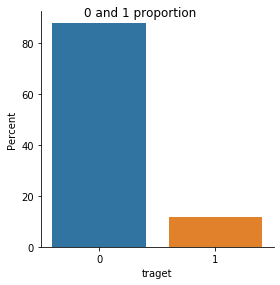

In [14]:
x_train_label_to_draw = pd.DataFrame(dict(traget=x_train_label))

pic_0_1 = sns.catplot(x="traget", y="traget", data=x_train_label_to_draw, kind="bar",\
                      height=4, aspect=1, estimator=lambda x: len(x) / len(x_train_label_to_draw) * 100)
                      
pic_0_1.set(ylabel="Percent")
pic_0_1.fig.suptitle("0 and 1 proportion")

print("0: {} %".format( round(x_train_label_to_draw.traget.value_counts()[0] / len(x_train_label_to_draw), 4)* 100 ) )
print("1: {} %".format( round(x_train_label_to_draw.traget.value_counts()[1] / len(x_train_label_to_draw), 4)* 100 ) )

    Check the distribution of 1 and 0 of each part of training label, so that the K-fold method would not fluctuate severly

In [15]:
def check_0_1_distribution(label_to_check): # a function to check the distribution of 1 and 0
    k_port = 5
    num_each_port = len(label_to_check) // k_port

    for i in range(k_port):
        num_0_num = 0
        num_1_num = 0
        for j in range(i*num_each_port , (i+1)*num_each_port):
            if(label_to_check[j] == 0):
                num_0_num += 1
            else:
                num_1_num += 1

        print("'0' has {}".format(num_0_num) + " and '1' has {}".format(num_1_num) + " in part {}".format(i+1) )
        print("'1' accounts for {}% of part {}.".format( round(num_1_num/(num_1_num+num_0_num)*100, 2) , i+1)   )
        print()

check_0_1_distribution(x_train_label)

'0' has 5199 and '1' has 703 in part 1
'1' accounts for 11.91% of part 1.

'0' has 5211 and '1' has 691 in part 2
'1' accounts for 11.71% of part 2.

'0' has 5184 and '1' has 718 in part 3
'1' accounts for 12.17% of part 3.

'0' has 5218 and '1' has 684 in part 4
'1' accounts for 11.59% of part 4.

'0' has 5192 and '1' has 710 in part 5
'1' accounts for 12.03% of part 5.



### 1. A function to build a model

In [16]:
from keras import models, layers, regularizers

def build_model(): # a function to build model
    model = models.Sequential()
    
    model.add(layers.Dense(120, activation="relu", kernel_regularizer = regularizers.l2(0.001), input_shape=(len(x_train[0]),) ) )
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(100, activation="relu", kernel_regularizer = regularizers.l2(0.001)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(60, activation="relu", kernel_regularizer = regularizers.l2(0.001)))
    model.add(layers.Dense(24, activation="relu", kernel_regularizer = regularizers.l2(0.001)))
    model.add(layers.Dense(24, activation="relu", kernel_regularizer = regularizers.l2(0.001)))
    model.add(layers.Dense(1, activation="sigmoid", kernel_regularizer = regularizers.l1_l2(0.001)))

    model.compile(optimizer= "rmsprop", loss= "binary_crossentropy", metrics=["accuracy"])
    
    return model


Using TensorFlow backend.


### 2. K-fold Validation with Class_weight

    K-fold to find the best number of epoch  

    Set class_weights, which we get from the previous step (0: 88%, 1:12%), to be {0:0.135, 1:1},  
    so that we can avoid the model tends to predict data as 0, beacuse there are more 0 than 1 in our training set

In [17]:
"""from sklearn.utils import class_weight"""

num_portion = 7
num_val_sameples = len(x_train) // num_portion
num_epochs = 20

# four lists to record loss, val_loss, acc, val_acc
all_loss = []
all_val_loss = []
all_acc = []
all_val_acc = []

for i in range(num_portion): # go through every part of validation
    print("processing fold {} ...".format(i+1))

    val_data = x_train[i*num_val_sameples : (i+1)*num_val_sameples]
    val_label = x_train_label[i*num_val_sameples : (i+1)*num_val_sameples]
    
    prartial_x_train = np.concatenate( [ x_train[: i*num_val_sameples], x_train[(i+1)*num_val_sameples: ] ], axis=0)

    prartial_x_train_label = np.concatenate( [ x_train_label[: i*num_val_sameples],\
                                                x_train_label[(i+1)*num_val_sameples: ] ], axis=0)

    model = build_model()
    class_weights = {0:0.135, 1:1} # set class_weights, so we can avoid that the model tends to predict data as 0
    """class_weight.compute_class_weight("balanced", np.unique(x_train_label), x_train_label.reshape(-1))"""

    history = model.fit(prartial_x_train, prartial_x_train_label, validation_data=(val_data, val_label), epochs=num_epochs,\
                        batch_size=512, verbose=0, class_weight=class_weights)

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    
    all_loss.append(loss)
    all_val_loss.append(val_loss)
    all_acc.append(acc)
    all_val_acc.append(val_acc)
    
    print()

print("< ====== K-fold Validation ends ====== >")

processing fold 1 ...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.

processing fold 2 ...

processing fold 3 ...

processing fold 4 ...

processing fold 5 ...

processing fold 6 ...

processing fold 7 ...

< ====== K-fold Validation ends ====== >


### 3. Plot the loss and accuracy of train data and validation data

In [18]:
average_all_loss = [ np.mean( [loss[i] for loss in all_loss] ) for i in range(num_epochs) ]
average_all_val_loss = [ np.mean( [val_loss[i] for val_loss in all_val_loss] ) for i in range(num_epochs) ]
average_all_acc = [ np.mean( [acc[i] for acc in all_acc] ) for i in range(num_epochs) ]
average_all_val_acc = [ np.mean( [val_acc[i] for val_acc in all_val_acc] ) for i in range(num_epochs) ]

#### I. loss of train data and validation data

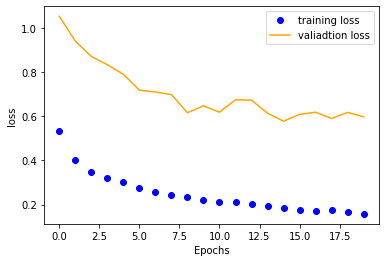

In [19]:
plt.plot(range(len(average_all_loss)), average_all_loss, 'bo', label = "training loss")
plt.plot(range(len(average_all_val_loss)), average_all_val_loss, 'b', color='orange', label = "valiadtion loss")

plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

#### II. Accuracy of train data and validation data

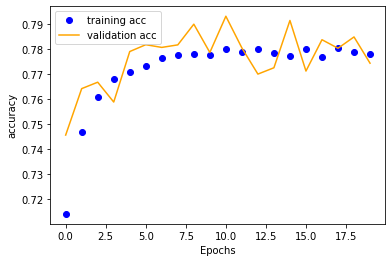

In [20]:
plt.clf()
plt.plot(range(len(average_all_acc)), average_all_acc, 'bo', label = "training acc")
plt.plot(range(len(average_all_val_acc)), average_all_val_acc, 'b', color='orange', label = "validation acc")

plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

## Step 5. Build models to predict test data

### 1. Use the best epoch got from K-fold Validation to build the model to predict test data

In [21]:
final_model = build_model()

class_weights = {0:0.135, 1:1} # set class_weights, so we can avoid that the model tends to predict data as 0
"""class_weight.compute_class_weight("balanced", np.unique(x_train_label), x_train_label.reshape(-1))"""

final_model.fit(x_train, x_train_label, epochs=15, batch_size=512, verbose=0, class_weight=class_weights)

answer = final_model.predict(x_test)

### 2. Transform the outcome of prediction (probability) into label 1 or 0

In [22]:
output = np.zeros(len(answer))
output = output.astype("int64")

for i, pred_y in enumerate(answer): # change the probability into 1 or 0
    if(pred_y[0] > 0.5): # if its probability is  larger than 0.5, we regard it as 1, esle we regard it as 0.
        output[i] = 1
    else:
        output[i] = 0

## Step 6. Output the outcome to csv

In [23]:
output = pd.DataFrame(data=output, columns=["Target"])

sub_try = pd.read_csv('sub_try.csv')  # read the ID of example output
sub_try.Target = output # set its Target as what we get from the prediction
output = sub_try # set output as whole sub_try dataframe, which has ID and its corresponding Target

output.to_csv('answer.csv', index = False) # output the outcome as csv document